In [229]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pyart
import xarray as xr
from datetime import datetime, timedelta
import glob
import metpy.calc as mpcalc
import metpy
import metpy.plots
from metpy.units import units
import cartopy.crs as ccrs
import gc
from astropy.convolution import convolve
from boto.s3.connection import S3Connection
import tempfile
import copy
import matplotlib
import math
import eccodes
import cfgrib

In [5]:
rotation_track = xr.open_dataset('/Users/juliabman/Desktop/grib_netcdf/20220523/rotationtrack235800.nc',)

In [281]:
az_shear = xr.open_dataset('/Users/juliabman/Desktop/az_shear_netcdf/20220523/azshear_235826.nc')

In [7]:
refl = xr.open_dataset('/Users/juliabman/Desktop/grib_netcdf/20220523/refl235841.nc')

In [8]:
lowlvlrefl = xr.open_dataset('/Users/juliabman/Desktop/grib_netcdf/20220523/lowlvlrefl235841.nc')

In [274]:
az_shear_grib = xr.open_dataset('/Users/juliabman/Desktop/az_shear_grib/MRMS_MergedAzShear_0-2kmAGL_00.50_20220523-235826.grib2')

In [276]:
name = '/Users/juliabman/Desktop/az_shear_grib/MRMS_MergedAzShear_0-2kmAGL_00.50_20220523-235826.grib2'

In [277]:
name[-12:-6]

'235826'

In [292]:
az_shear_grib

<xarray.Dataset>
Dimensions:         (latitude: 7000, longitude: 14000)
Coordinates:
    time            datetime64[ns] ...
    step            timedelta64[ns] ...
    heightAboveSea  float64 ...
  * latitude        (latitude) float64 55.0 54.99 54.99 ... 20.01 20.01 20.0
  * longitude       (longitude) float64 230.0 230.0 230.0 ... 300.0 300.0 300.0
    valid_time      datetime64[ns] ...
Data variables:
    unknown         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2024-08-08T16:53 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
az_shear

<xarray.Dataset>
Dimensions:                                       (latitude: 7000,
                                                   longitude: 14000, time: 1)
Coordinates:
  * latitude                                      (latitude) float64 20.0 ......
  * longitude                                     (longitude) float64 -130.0 ...
  * time                                          (time) datetime64[ns] 2022-...
Data variables:
    MergedAzShear0to2kmAGL_500mabovemeansealevel  (time, latitude, longitude) float32 ...
Attributes:
    Conventions:          COARDS
    History:              created by wgrib2
    GRIB2_grid_template:  0

In [14]:
az_shear.MergedAzShear0to2kmAGL_500mabovemeansealevel

<xarray.DataArray 'MergedAzShear0to2kmAGL_500mabovemeansealevel' (time: 1,
                                                                  latitude: 7000,
                                                                  longitude: 14000)>
[98000000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 20.0 20.01 20.01 20.02 ... 54.99 54.99 55.0
  * longitude  (longitude) float64 -130.0 -130.0 -130.0 ... -60.01 -60.01 -60.0
  * time       (time) datetime64[ns] 2022-05-23T23:58:26
Attributes:
    short_name:  MergedAzShear0to2kmAGL_500mabovemeansealevel
    long_name:   Azimuth Shear 0-2km AGL
    level:       500 m above mean sea level
    units:       0.001/s

In [15]:
np.shape(az_shear.MergedAzShear0to2kmAGL_500mabovemeansealevel.values)

(1, 7000, 14000)

In [16]:
np.shape(az_shear.MergedAzShear0to2kmAGL_500mabovemeansealevel[0].values)

(7000, 14000)

In [17]:
az_shear.MergedAzShear0to2kmAGL_500mabovemeansealevel[0,0,:]

<xarray.DataArray 'MergedAzShear0to2kmAGL_500mabovemeansealevel' (
                                                                  longitude: 14000)>
array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
Coordinates:
    latitude   float64 20.0
  * longitude  (longitude) float64 -130.0 -130.0 -130.0 ... -60.01 -60.01 -60.0
    time       datetime64[ns] 2022-05-23T23:58:26
Attributes:
    short_name:  MergedAzShear0to2kmAGL_500mabovemeansealevel
    long_name:   Azimuth Shear 0-2km AGL
    level:       500 m above mean sea level
    units:       0.001/s

In [18]:
morton_lat_lower_i =  az_shear.MergedAzShear0to2kmAGL_500mabovemeansealevel.latitude > 33.5

In [19]:
morton_lat_lower_i

<xarray.DataArray 'latitude' (latitude: 7000)>
array([False, False, False, ...,  True,  True,  True])
Coordinates:
  * latitude  (latitude) float64 20.0 20.01 20.01 20.02 ... 54.99 54.99 55.0

In [20]:
morton_lat_l_i = np.where(morton_lat_lower_i == True)

In [21]:
morton_lat_l_i

(array([2700, 2701, 2702, ..., 6997, 6998, 6999]),)

In [22]:
morton_lat_array = np.array(morton_lat_l_i).flatten()

In [23]:
np.shape(morton_lat_array)

(4300,)

In [24]:
morton_lat_array

array([2700, 2701, 2702, ..., 6997, 6998, 6999])

In [25]:
morton_lon_low_i = az_shear.MergedAzShear0to2kmAGL_500mabovemeansealevel.longitude > -103

In [26]:
morton_lon_l_i = np.where(morton_lon_low_i == True)

In [27]:
morton_lon_array = np.array(morton_lon_l_i).flatten()

In [28]:
morton_low_bounds = az_shear.MergedAzShear0to2kmAGL_500mabovemeansealevel[:, morton_lat_array, morton_lon_array]

In [29]:
morton_low_bounds

<xarray.DataArray 'MergedAzShear0to2kmAGL_500mabovemeansealevel' (time: 1,
                                                                  latitude: 4300,
                                                                  longitude: 8600)>
array([[[1., 1., ..., 0., 0.],
        [1., 1., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 33.5 33.51 33.51 33.52 ... 54.99 54.99 55.0
  * longitude  (longitude) float64 -103.0 -103.0 -103.0 ... -60.01 -60.01 -60.0
  * time       (time) datetime64[ns] 2022-05-23T23:58:26
Attributes:
    short_name:  MergedAzShear0to2kmAGL_500mabovemeansealevel
    long_name:   Azimuth Shear 0-2km AGL
    level:       500 m above mean sea level
    units:       0.001/s

In [33]:
morton_lat_upper_i = morton_low_bounds.latitude < 34

In [34]:
morton_lat_upper_i

<xarray.DataArray 'latitude' (latitude: 4300)>
array([ True,  True,  True, ..., False, False, False])
Coordinates:
  * latitude  (latitude) float64 33.5 33.51 33.51 33.52 ... 54.99 54.99 55.0

In [35]:
morton_lat_u_i = np.where(morton_lat_upper_i == True)

In [36]:
morton_lat_u_i

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),)

In [37]:
morton_upper_lat_array = np.array(morton_lat_u_i).flatten()

In [38]:
morton_lon_upper_i = morton_low_bounds.longitude < -102

In [39]:
morton_lon_u_i = np.where(morton_lon_upper_i == True)

In [40]:
morton_upper_lon_array = np.array(morton_lon_u_i).flatten()

In [41]:
morton_bounded = morton_low_bounds[:, morton_upper_lat_array, morton_upper_lon_array]

In [42]:
morton_bounded

<xarray.DataArray 'MergedAzShear0to2kmAGL_500mabovemeansealevel' (time: 1,
                                                                  latitude: 100,
                                                                  longitude: 200)>
array([[[1., 1., ..., 0., 0.],
        [1., 1., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 33.5 33.51 33.51 33.52 ... 33.99 33.99 34.0
  * longitude  (longitude) float64 -103.0 -103.0 -103.0 ... -102.0 -102.0 -102.0
  * time       (time) datetime64[ns] 2022-05-23T23:58:26
Attributes:
    short_name:  MergedAzShear0to2kmAGL_500mabovemeansealevel
    long_name:   Azimuth Shear 0-2km AGL
    level:       500 m above mean sea level
    units:       0.001/s

In [43]:
why = np.where(morton_bounded > 15)

In [44]:
morton_bounded[why][0]

<xarray.DataArray 'MergedAzShear0to2kmAGL_500mabovemeansealevel' (latitude: 6,
                                                                  longitude: 6)>
array([[16., 18., 17., 16., 18., 18.],
       [16., 18., 17., 16., 18., 18.],
       [16., 18., 17., 16., 18., 18.],
       [16., 19., 12., 16., 19., 19.],
       [16., 19., 12., 16., 19., 19.],
       [14., 17., 12., 14., 17., 17.]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 33.81 33.81 33.81 33.82 33.82 33.82
  * longitude  (longitude) float64 -102.8 -102.8 -102.8 -102.8 -102.8 -102.8
    time       datetime64[ns] 2022-05-23T23:58:26
Attributes:
    short_name:  MergedAzShear0to2kmAGL_500mabovemeansealevel
    long_name:   Azimuth Shear 0-2km AGL
    level:       500 m above mean sea level
    units:       0.001/s

In [45]:
morton_bounded[why][0].longitude

<xarray.DataArray 'longitude' (longitude: 6)>
array([-102.812501, -102.807501, -102.802501, -102.812501, -102.807501,
       -102.807501])
Coordinates:
  * longitude  (longitude) float64 -102.8 -102.8 -102.8 -102.8 -102.8 -102.8
    time       datetime64[ns] 2022-05-23T23:58:26
Attributes:
    units:      degrees_east
    long_name:  longitude

In [46]:
morton_bounded[why][0].time.data

array('2022-05-23T23:58:26.000000000', dtype='datetime64[ns]')

In [47]:
np.shape(morton_bounded[why])

(6, 6, 6)

/var/folders/4f/9s_4__q16tx5t8vmww4mv03h0000gn/T/ipykernel_43783/1766528729.py:2: UserWarning: The following kwargs were not used by contour: 'ccmap'
  plt.contourf(morton_bounded[0].longitude, morton_bounded[0].latitude,


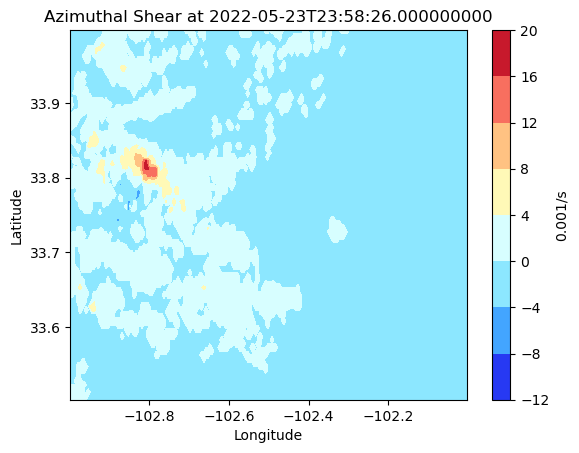

In [48]:
fig = plt.figure()
plt.contourf(morton_bounded[0].longitude, morton_bounded[0].latitude, 
             morton_bounded[0].values, cmap = 'pyart_BuDRd12', ccmap = 'PlateCaree')
plt.ticklabel_format(useOffset=False)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label = '0.001/s')
plt.title(f'Azimuthal Shear at {morton_bounded[0].time.data}')
plt.show()

In [185]:
morton_bounded

<xarray.DataArray 'MergedAzShear0to2kmAGL_500mabovemeansealevel' (time: 1,
                                                                  latitude: 100,
                                                                  longitude: 200)>
array([[[1., 1., ..., 0., 0.],
        [1., 1., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 33.5 33.51 33.51 33.52 ... 33.99 33.99 34.0
  * longitude  (longitude) float64 -103.0 -103.0 -103.0 ... -102.0 -102.0 -102.0
  * time       (time) datetime64[ns] 2022-05-23T23:58:26
Attributes:
    short_name:  MergedAzShear0to2kmAGL_500mabovemeansealevel
    long_name:   Azimuth Shear 0-2km AGL
    level:       500 m above mean sea level
    units:       0.001/s

In [172]:
morton_bounded[0].shape

(100, 200)

In [49]:
max_shear_index = np.unravel_index(np.argmax(morton_bounded[0].values), morton_bounded[0].shape)

In [174]:
max_shear_index

(63, 38)

In [173]:
np.shape(max_shear_index)

(2,)

In [181]:
max_shear = morton_bounded[0][max_shear_index]

In [182]:
max_shear

<xarray.DataArray 'MergedAzShear0to2kmAGL_500mabovemeansealevel' ()>
array(19., dtype=float32)
Coordinates:
    latitude   float64 33.82
    longitude  float64 -102.8
    time       datetime64[ns] 2022-05-23T23:58:26
Attributes:
    short_name:  MergedAzShear0to2kmAGL_500mabovemeansealevel
    long_name:   Azimuth Shear 0-2km AGL
    level:       500 m above mean sea level
    units:       0.001/s

In [187]:
np.shape(max_shear)

()

In [184]:
np.shape(max_shear.latitude)

()

In [155]:
def get_az_shear(az_shear_var, lower_lat_bound, lower_lon_bound, upper_lat_bound, upper_lon_bound):
    """
    """
    low_lat_bool = az_shear_var.latitude > lower_lat_bound
    low_lat_idx = np.where(low_lat_bool == True)
    low_lat_array = np.array(low_lat_idx).flatten()
    
    low_lon_bool = az_shear_var.longitude > lower_lon_bound
    low_lon_idx = np.where(low_lon_bool == True)
    low_lon_array = np.array(low_lon_idx).flatten()

    low_bounds = az_shear_var[:, low_lat_array, low_lon_array]

    high_lat_bool = low_bounds.latitude < upper_lat_bound
    high_lat_idx = np.where(high_lat_bool == True)
    high_lat_array = np.array(high_lat_idx).flatten()
    
    high_lon_bool = low_bounds.longitude < upper_lon_bound
    high_lon_idx = np.where(high_lon_bool == True)
    high_lon_array = np.array(high_lon_idx).flatten()

    bounded_area = low_bounds[:, high_lat_array, high_lon_array]

    max_shear_index = np.unravel_index(np.argmax(bounded_area[0].values), bounded_area[0].shape)
    max_shear = morton_bounded[0][max_shear_index]

    return bounded_area, max_shear
    

In [298]:
azshear_213614 = xr.open_dataset('/Users/juliabman/Desktop/az_shear_netcdf/20220523/azshear_213614.nc')

In [299]:
azshear_213614

<xarray.Dataset>
Dimensions:                                       (latitude: 7000,
                                                   longitude: 14000, time: 1)
Coordinates:
  * latitude                                      (latitude) float64 20.0 ......
  * longitude                                     (longitude) float64 -130.0 ...
  * time                                          (time) datetime64[ns] 2022-...
Data variables:
    MergedAzShear0to2kmAGL_500mabovemeansealevel  (time, latitude, longitude) float32 ...
Attributes:
    Conventions:          COARDS
    History:              created by wgrib2
    GRIB2_grid_template:  0

In [270]:
folder = sorted(glob.glob('/Users/juliabman/Desktop/az_shear_grib/*.grib2'))

In [311]:
for file in folder[0:1]:
    read = xr.open_dataset(file, engine='cfgrib')
    grib_to_netcdf = read.to_netcdf(f'/Users/juliabman/Desktop/az_shear_netcdf/20220523/azshear_{file[-12:-6]}.nc', 
                                    format='NETCDF4', engine = 'netcdf4')

In [312]:
folder2 = sorted(glob.glob('/Users/juliabman/Desktop/az_shear_netcdf/20220523/*.nc'))

In [313]:
folder2[0]

'/Users/juliabman/Desktop/az_shear_netcdf/20220523/azshear_213614.nc'

In [314]:
xr.open_dataset(folder[0])

<xarray.Dataset>
Dimensions:         (latitude: 7000, longitude: 14000)
Coordinates:
    time            datetime64[ns] ...
    step            timedelta64[ns] ...
    heightAboveSea  float64 ...
  * latitude        (latitude) float64 55.0 54.99 54.99 ... 20.01 20.01 20.0
  * longitude       (longitude) float64 230.0 230.0 230.0 ... 300.0 300.0 300.0
    valid_time      datetime64[ns] ...
Data variables:
    unknown         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2024-08-09T13:57 GRIB to CDM+CF via cfgrib-0.9.1...

In [428]:
# max_shears = []
# for file in folder2[0:10]:
#     read = xr.open_dataset(file)
#     print(read)
#     az_shear = read.MergedAzShear0to2kmAGL_500mabovemeansealevel
#     lower_lat_bound = 33.5
#     lower_lon_bound = -103
#     upper_lat_bound = 34
#     upper_lon_bound = -102
#     bounded, max_shear = get_az_shear(az_shear, lower_lat_bound, lower_lon_bound, upper_lat_bound, upper_lon_bound)
#     max_shears.append(max_shear)

In [152]:
test, shear = get_az_shear(az_shear.MergedAzShear0to2kmAGL_500mabovemeansealevel, 33.5, -103, 34, -102)

In [153]:
test

<xarray.DataArray 'MergedAzShear0to2kmAGL_500mabovemeansealevel' (time: 1,
                                                                  latitude: 100,
                                                                  longitude: 200)>
array([[[1., 1., ..., 0., 0.],
        [1., 1., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 33.5 33.51 33.51 33.52 ... 33.99 33.99 34.0
  * longitude  (longitude) float64 -103.0 -103.0 -103.0 ... -102.0 -102.0 -102.0
  * time       (time) datetime64[ns] 2022-05-23T23:58:26
Attributes:
    short_name:  MergedAzShear0to2kmAGL_500mabovemeansealevel
    long_name:   Azimuth Shear 0-2km AGL
    level:       500 m above mean sea level
    units:       0.001/s

In [154]:
shear

<xarray.DataArray 'MergedAzShear0to2kmAGL_500mabovemeansealevel' ()>
array(19., dtype=float32)
Coordinates:
    latitude   float64 33.82
    longitude  float64 -102.8
    time       datetime64[ns] 2022-05-23T23:58:26
Attributes:
    short_name:  MergedAzShear0to2kmAGL_500mabovemeansealevel
    long_name:   Azimuth Shear 0-2km AGL
    level:       500 m above mean sea level
    units:       0.001/s

In [165]:
np.shape(shear)

()

In [282]:
azshear2356 = xr.open_dataset('/Users/juliabman/Desktop/az_shear_netcdf/20220523/azshear_235618.nc')

In [157]:
test2, shear2 = get_az_shear(azshear2356.MergedAzShear0to2kmAGL_500mabovemeansealevel, 33.5, -103, 34, -102)

In [158]:
test2

<xarray.DataArray 'MergedAzShear0to2kmAGL_500mabovemeansealevel' (time: 1,
                                                                  latitude: 100,
                                                                  longitude: 200)>
[20000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 33.5 33.51 33.51 33.52 ... 33.99 33.99 34.0
  * longitude  (longitude) float64 -103.0 -103.0 -103.0 ... -102.0 -102.0 -102.0
  * time       (time) datetime64[ns] 2022-05-23T23:56:18
Attributes:
    short_name:  MergedAzShear0to2kmAGL_500mabovemeansealevel
    long_name:   Azimuth Shear 0-2km AGL
    level:       500 m above mean sea level
    units:       0.001/s

In [159]:
shear2

<xarray.DataArray 'MergedAzShear0to2kmAGL_500mabovemeansealevel' ()>
array(19., dtype=float32)
Coordinates:
    latitude   float64 33.82
    longitude  float64 -102.8
    time       datetime64[ns] 2022-05-23T23:58:26
Attributes:
    short_name:  MergedAzShear0to2kmAGL_500mabovemeansealevel
    long_name:   Azimuth Shear 0-2km AGL
    level:       500 m above mean sea level
    units:       0.001/s

In [164]:
np.shape(shear2)

()

In [217]:
a = pd.Series(shear.latitude.data)
b = pd.Series(shear2.latitude.data)

In [205]:
c = pd.concat([a,b])

In [200]:
c

0    33.81750060522932
0    33.81750060522932
dtype: object

In [218]:
d = pd.Series(shear.data)
e = pd.Series(shear2.data)

In [208]:
f = pd.concat([d,e])

In [209]:
f

0    19.0
0    19.0
dtype: object

In [210]:
g = pd.concat([c,f], axis=1)

In [211]:
g

,0,1
0,33.81750060522932,19.0
0,33.81750060522932,19.0


In [219]:
h = pd.Series(shear.time.data)
i = pd.Series(shear2.time.data)

j = pd.concat([h,i])

In [226]:
def get_radar_from_aws(site, datetime_t, datetime_te):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
            
    # find the closest available radar to your datetime
    closest_datetime_b = _nearestDate(datetimes, datetime_t)
    closest_datetime_e = _nearestDate(datetimes, datetime_te)

    index_b = datetimes.index(closest_datetime_b)
    index_e = datetimes.index(closest_datetime_e)

    radar_namelist = keys[index_b:index_e+1]
    radar_list=[]
    for i in range(np.shape(radar_namelist)[0]):
        localfile = tempfile.NamedTemporaryFile()
        radar_namelist[i].get_contents_to_filename(localfile.name)
        radar_list.append(pyart.io.read(localfile.name))
        
    return radar_namelist,radar_list

In [256]:
conn = S3Connection(anon = True)
bucket = conn.get_bucket('noaa-mrms-pds')

In [263]:
import boto3
s3_paginator = boto3.client('s3').get_paginator('list_objects_v2')

def keys(bucket_name, prefix='/', delimiter='/', start_after=''):
    bucket_list = []
    prefix = prefix.lstrip(delimiter)
    start_after = (start_after or prefix) if prefix.endswith(delimiter) else start_after
    for page in s3_paginator.paginate(Bucket=bucket_name, Prefix=prefix, StartAfter=start_after):
        for content in page.get('Contents', ()):
            yield content['Key']
            bucket_list.append(content['Key'])
            return bucket_list

In [266]:
please_work, um = keys('noaa-mrms-pds',prefix='CONUS/MergedAzShear_0-2kmAGL_00.50/20220523', delimiter='/', start_after='')

NoCredentialsError: Unable to locate credentials

In [265]:
please_work

<generator object keys at 0x379903eb0>

In [250]:
list = bucket.list('CONUS/MergedAzShear_0-2kmAGL_00.50/20220523')

In [251]:
list

In [246]:
from boto3 import client

connect = client('s3')
for key in connect.list_objects(Bucket='noaa-mrms-pds', Prefix='CONUS/MergedAzShear_0-2kmAGL_00.50/20220523')['Contents'][0:10]:
    print(key['Key'])

NoCredentialsError: Unable to locate credentials

In [323]:
gribcdf = xr.open_dataset('/Users/juliabman/Desktop/concat_test/small_grib.nc')

In [324]:
gribcdf

<xarray.Dataset>
Dimensions:                                       (latitude: 100,
                                                   longitude: 200, time: 1)
Coordinates:
  * latitude                                      (latitude) float64 33.5 ......
  * longitude                                     (longitude) float64 -103.0 ...
  * time                                          (time) datetime64[ns] 2022-...
Data variables:
    MergedAzShear0to2kmAGL_500mabovemeansealevel  (time, latitude, longitude) float32 ...
Attributes:
    Conventions:          COARDS
    History:              created by wgrib2
    GRIB2_grid_template:  0

In [328]:
big_grib_grib = xr.open_dataset('/Users/juliabman/Desktop/concat_test/big_grib.grb2')

In [330]:
big_grib_grib

<xarray.Dataset>
Dimensions:         (time: 8, latitude: 100, longitude: 200)
Coordinates:
  * time            (time) datetime64[ns] 2022-05-23T21:36:00 ... 2022-05-23T...
    step            timedelta64[ns] ...
    heightAboveSea  float64 ...
  * latitude        (latitude) float64 33.5 33.51 33.51 ... 33.99 33.99 34.0
  * longitude       (longitude) float64 257.0 257.0 257.0 ... 258.0 258.0 258.0
    valid_time      (time) datetime64[ns] ...
Data variables:
    unknown         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2024-08-09T16:58 GRIB to CDM+CF via cfgrib-0.9.1...

In [329]:
big_grib_nc = xr.open_dataset('/Users/juliabman/Desktop/concat_test/big_grib.nc')

In [331]:
big_grib_nc

<xarray.Dataset>
Dimensions:                                       (latitude: 100,
                                                   longitude: 200, time: 8)
Coordinates:
  * latitude                                      (latitude) float64 33.5 ......
  * longitude                                     (longitude) float64 -103.0 ...
  * time                                          (time) datetime64[ns] 2022-...
Data variables:
    MergedAzShear0to2kmAGL_500mabovemeansealevel  (time, latitude, longitude) float32 ...
Attributes:
    Conventions:          COARDS
    History:              created by wgrib2
    GRIB2_grid_template:  0

In [342]:
big_grib_nc.MergedAzShear0to2kmAGL_500mabovemeansealevel[0,:,:]

<xarray.DataArray 'MergedAzShear0to2kmAGL_500mabovemeansealevel' (
                                                                  latitude: 100,
                                                                  longitude: 200)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 33.5 33.51 33.51 33.52 ... 33.99 33.99 34.0
  * longitude  (longitude) float64 -103.0 -103.0 -103.0 ... -102.0 -102.0 -102.0
    time       datetime64[ns] 2022-05-23T21:36:14
Attributes:
    short_name:  MergedAzShear0to2kmAGL_500mabovemeansealevel
    long_name:   Azimuth Shear 0-2km AGL
    level:       500 m above mean sea level
    units:       0.001/s

In [453]:
big_grib_nc.time.data

array(['2022-05-23T21:36:14.000000000', '2022-05-23T21:38:19.000000000',
       '2022-05-23T21:40:15.000000000', '2022-05-23T21:42:18.000000000',
       '2022-05-23T21:44:14.000000000', '2022-05-23T21:46:20.000000000',
       '2022-05-23T21:48:28.000000000', '2022-05-23T21:50:26.000000000'],
      dtype='datetime64[ns]')

In [491]:
lats = pd.Series([])
lons = pd.Series([])
times = pd.Series([])
shear = pd.Series([])
lat_list = []
lon_list = []
time_list = []
shear_list = []
for i in range(len(big_grib_nc.time)):
    azshear = big_grib_nc.MergedAzShear0to2kmAGL_500mabovemeansealevel[i,:,:]
    max_shear_index = np.unravel_index(np.argmax(azshear.values), azshear.shape)
    max_shear = azshear[max_shear_index]
    time_datetime = max_shear.time.data.astype('datetime64[s]')
    lat_list.append(max_shear.latitude.data)
    lon_list.append(max_shear.longitude.data)
    time_list.append(time_datetime)
    shear_list.append(max_shear.data)
    max_lat = pd.Series(max_shear.latitude.data)
    max_lon = pd.Series(max_shear.longitude.data)
    max_time = pd.Series(time_datetime)
    max_shear_a = pd.Series(max_shear.data)
    lats = pd.concat([lats, max_lat], names = 'latitude')
    lons = pd.concat([lons, max_lon], names = 'longitude')
    times = pd.concat([times, max_time], names = 'times')
    shears = pd.concat([shears, max_shear_a], names = 'shears')

In [450]:
max_shear

<xarray.DataArray 'MergedAzShear0to2kmAGL_500mabovemeansealevel' ()>
array(2., dtype=float32)
Coordinates:
    latitude   float64 33.53
    longitude  float64 -102.0
    time       datetime64[ns] 2022-05-23T21:50:26
Attributes:
    short_name:  MergedAzShear0to2kmAGL_500mabovemeansealevel
    long_name:   Azimuth Shear 0-2km AGL
    level:       500 m above mean sea level
    units:       0.001/s

In [492]:
shear_list

[array(1., dtype=float32),
 array(1., dtype=float32),
 array(2., dtype=float32),
 array(2., dtype=float32),
 array(2., dtype=float32),
 array(2., dtype=float32),
 array(2., dtype=float32),
 array(2., dtype=float32)]

In [487]:
lat_list

[array(33.5025),
 array(33.5025),
 array(33.6625),
 array(33.6625),
 array(33.5425),
 array(33.5425),
 array(33.5275),
 array(33.5275)]

In [488]:
time_list

[array('2022-05-23T21:36:14', dtype='datetime64[s]'),
 array('2022-05-23T21:38:19', dtype='datetime64[s]'),
 array('2022-05-23T21:40:15', dtype='datetime64[s]'),
 array('2022-05-23T21:42:18', dtype='datetime64[s]'),
 array('2022-05-23T21:44:14', dtype='datetime64[s]'),
 array('2022-05-23T21:46:20', dtype='datetime64[s]'),
 array('2022-05-23T21:48:28', dtype='datetime64[s]'),
 array('2022-05-23T21:50:26', dtype='datetime64[s]')]

In [460]:
times

0    2022-05-23T21:36:14
0    2022-05-23T21:38:19
0    2022-05-23T21:40:15
0    2022-05-23T21:42:18
0    2022-05-23T21:44:14
0    2022-05-23T21:46:20
0    2022-05-23T21:48:28
0    2022-05-23T21:50:26
dtype: object

In [456]:
lats

0               33.5025
0               33.5025
0    33.662499999999994
0    33.662499999999994
0               33.5425
0               33.5425
0    33.527499999999996
0    33.527499999999996
dtype: object

In [446]:
np.shape(lats)

(8,)

In [406]:
np.shape(max_shear.data)

()

In [416]:
morton_df = pd.concat([lats,lons,times], names= ['latitude', 'longitude', 'times'], axis=1)

In [426]:
morton_df.rename(columns = {0:'latitude', 1:'longitude', 2:'time'}, inplace = True)

In [463]:
morton_df.reset_index()

,index,latitude,longitude,time
0,0,33.5025,-102.6675010000003,2022-05-23T21:36:14.000000000
1,0,33.5025,-102.6675010000003,2022-05-23T21:38:19.000000000
2,0,33.662499999999994,-102.09250100000082,2022-05-23T21:40:15.000000000
3,0,33.662499999999994,-102.09250100000082,2022-05-23T21:42:18.000000000
4,0,33.5425,-102.01750100000089,2022-05-23T21:44:14.000000000
5,0,33.5425,-102.01750100000089,2022-05-23T21:46:20.000000000
6,0,33.527499999999996,-102.0025010000009,2022-05-23T21:48:28.000000000
7,0,33.527499999999996,-102.0025010000009,2022-05-23T21:50:26.000000000


In [482]:
morton_df.drop(columns = 'index')

KeyError: "['index'] not found in axis"

Put make_shear_df function into a for loop that iterates over the datetimes, or maybe use list of datetimes??

In [465]:
def find_nearest(array, value):
    '''
    Function to find index of the array in which the value is closest to

    Parameters: array (array), value (number)
    Returns: index (int)

    Example: xind = CM1calc.find_nearest(x,5)
    '''

    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return idx

In [497]:
def nearest_tobac_time(netcdf_list, morton_tobac_lats, morton_tobac_lons, morton_tobac_times_datetime):
    '''
    To run this function, you must make sure you've pre-defined the generic find_nearest function first.
    This function does NOT need tobac inputs to run, it can be time, lat, and lon data from any source.
    The input lats, lons, and times MUST BE ARRAYS. They CANNOT be: Series, lists, etc.
    ---
    Inputs:
    netcdf_list = usually a sorted glob of netcdfs converted from RAW radar data
    morton_tobac_lons = an array of longitudes that correspond to the feature of interest (i.e. meso location)
    morton_tobac_lats = same as lons
    morton_tobac_times_datetime = an array of the feature's datetimes to compare the radar data times to
    '''
    time_list = []
    for netcdf_file in netcdf_list:
        time_yoink = netcdf_file[-15:-3]
        #print(time_yoink)
        time_yoink_dt = datetime.strptime(time_yoink, '%y%m%d%H%M%S')
        time_list.append(time_yoink_dt)
        
    time_yoink_dt_array = np.array(time_list)
    time_yoink_dt_convert = time_yoink_dt_array.astype('datetime64[s]')
    time_yoink_dt_series = pd.Series(time_yoink_dt_convert)
    
    nearest_tobac_index = []
    for time in time_yoink_dt_convert:
        print(time)
        tobac_index = find_nearest(morton_tobac_times_datetime, time)
        nearest_tobac_index.append(tobac_index)
        
    tobac_times_closest = morton_tobac_times_datetime[nearest_tobac_index]
    series_tobac_times = pd.Series(tobac_times_closest)
    series_tobac_indeces = pd.Series(nearest_tobac_index)
    
    tobac_lats_closest = morton_tobac_lats[nearest_tobac_index]
    series_tobac_lats = pd.Series(tobac_lats_closest)
    tobac_lons_closest = morton_tobac_lons[nearest_tobac_index]
    series_tobac_lons = pd.Series(tobac_lons_closest)

    return time_yoink_dt_series, series_tobac_times, series_tobac_indeces, series_tobac_lats, series_tobac_lons

In [496]:
ka1_vads = sorted(glob.glob('/Users/juliabman/Desktop/term_corr_qc/ka1/*.nc'))

In [476]:
np.shape(ka1_vads)

(83,)

In [477]:
ka1_vads_1 = ka1_vads[0]

In [494]:
vad_times, mrms_times, mrms_indeces, mrms_lats, mrms_lons = nearest_tobac_time(ka1_vads[:20], np.array(lat_list),
                                                                               np.array(lon_list), 
                                                                               np.array(morton_df.time).astype('datetime64[s]'))

2022-05-23T22:55:10
2022-05-23T22:55:40
2022-05-23T22:56:10
2022-05-23T22:56:39
2022-05-23T22:57:09
2022-05-23T22:57:40
2022-05-23T22:58:09
2022-05-23T22:58:39
2022-05-23T22:59:10
2022-05-23T22:59:40
2022-05-23T23:00:10
2022-05-23T23:00:40
2022-05-23T23:01:10
2022-05-23T23:01:41
2022-05-23T23:02:11
2022-05-23T23:02:40
2022-05-23T23:15:58
2022-05-23T23:16:27
2022-05-23T23:16:57
2022-05-23T23:17:26


In [495]:
mrms_times

0    2022-05-23 21:50:26
1    2022-05-23 21:50:26
2    2022-05-23 21:50:26
3    2022-05-23 21:50:26
4    2022-05-23 21:50:26
5    2022-05-23 21:50:26
6    2022-05-23 21:50:26
7    2022-05-23 21:50:26
8    2022-05-23 21:50:26
9    2022-05-23 21:50:26
10   2022-05-23 21:50:26
11   2022-05-23 21:50:26
12   2022-05-23 21:50:26
13   2022-05-23 21:50:26
14   2022-05-23 21:50:26
15   2022-05-23 21:50:26
16   2022-05-23 21:50:26
17   2022-05-23 21:50:26
18   2022-05-23 21:50:26
19   2022-05-23 21:50:26
dtype: datetime64[s]

In [ ]:
def make_shear_df(site, datetime):
    '''
    This function pulls MergedAzimuthalShear data from the MRMS database 
    (https://noaa-mrms-pds.s3.amazonaws.com/index.html#CONUS/MergedAzShear_0-2kmAGL_00.50)
    and makes a dataframe for the maximum shear value and its corresponding lat and lon per desired time step.
    '''
    bounds_da, max_shear_da = get_az_shear(az_shear_var, lower_lat_bound, lower_lon_bound, 
                                           upper_lat_bound, upper_lon_bound)
    bucket
 
    empty_lat_series = pd.Series([])
    lat_series = pd.Series(max_shear_da.latitude.data)
    